<a href="https://colab.research.google.com/github/prikshit-2000/Tensorflow/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [12]:
import urllib.request
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from shutil import copyfile
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
data_file_name = 'catsdogs.zip'
download_dir = '/tmp'
urllib.request.urlretrieve(data_url,data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [3]:
print("Number of cat images:",len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of dog images: ",len(os.listdir('/tmp/PetImages/Dog/')))

Number of cat images: 12501
Number of dog images:  12501


In [4]:
try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
  pass

In [5]:
import random
from shutil import copyfile
def split_data(SOURCE,TRAINING,TESTING,SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename  + "is zero length so ignoring")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files,len(files))
  training_set = shuffled_set[0:training_length]
  testing_set  = shuffled_set[training_length:]

  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file,destination)

  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file,destination)

CAT_SOURCE_DIR = '/tmp/PetImages/Cat/'
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"


split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


666.jpgis zero length so ignoring
11702.jpgis zero length so ignoring


In [6]:

print("Number of training cat images", len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print("Number of training dog images", len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print("Number of testing cat images", len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print("Number of testing dog images", len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# expected output
# Number of training cat images 11250
# Number of training dog images 11250
# Number of testing cat images 1250
# Number of testing dog images 1250

Number of training cat images 11250
Number of training dog images 11250
Number of testing cat images 1250
Number of testing dog images 1250


In [7]:
TRAINING_DIR = '/tmp/cats-v-dogs/training/'

train_datagen  = ImageDataGenerator(rescale = 1.0/255,
                                 rotation_range = 40,
                                 width_shift_range= 0.2,
                                 height_shift_range = 0.2,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 horizontal_flip = True,
                                 fill_mode = 'nearest'   )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = 100,
                                                    class_mode = 'binary',
                                                    target_size = (150,150))
VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'

validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = 100,
                                                    class_mode = 'binary',
                                                    target_size = (150,150))

Found 22498 images belonging to 2 classes.
Found 22498 images belonging to 2 classes.


In [21]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = 'inception_v3.h5'
urllib.request.urlretrieve(weights_url,weights_file)


pre_trained_model = InceptionV3(input_shape  = (150,150,3),
                                include_top  = False,
                                weights ='imagenet')
# pre_trained_model.load_weights(weights_file)


87924736/87910968 [==============================] - 1s 0us/step


In [10]:
for layer in pre_trained_model.layers:
  layer.trainable = False
# pre_trained_model.summary()
last_layer = pre_trained_model.get_layer('mixed7')
print("last layer output shape :" , last_layer.output_shape)
last_output = last_layer.output


last layer output shape : (None, 7, 7, 768)


In [13]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024 , activation = 'relu')(x)
x = layers.Dense(1 , activation = 'sigmoid')(x)
model = Model(pre_trained_model.input,x)

In [14]:
model.compile(optimizer = RMSprop(lr = 0.0001),
              loss  = 'binary_crossentropy',
              metrics = ['acc']
              )

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 2,
                    verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/2
117/225 [==============>...............] - ETA: 1:33 - loss: 0.2753 - acc: 0.8961

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 311s 1s/step - loss: 0.2243 - acc: 0.9126 - val_loss: 0.0902 - val_acc: 0.9644
Epoch 2/2
225/225 [==============================] - 272s 1s/step - loss: 0.1533 - acc: 0.9361 - val_loss: 0.0761 - val_acc: 0.9702


<Figure size 432x288 with 0 Axes>

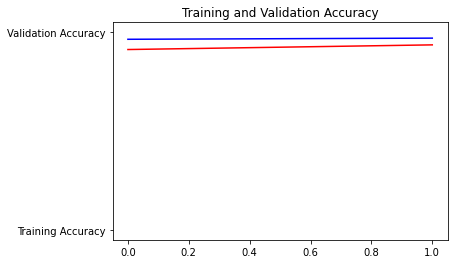

<Figure size 432x288 with 0 Axes>

In [16]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs , acc , 'r' , "Training Accuracy")
plt.plot(epochs , val_acc ,'b' , "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.figure()




In [18]:
import numpy as np
from google.colab import files

from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  path = '/content/' + fn

  img = image.load_img(path , target_size = (150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x , axis = 0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a dog")

  else:
    print(fn + " is a cat")


Saving Image.jpeg to Image.jpeg
[[1.]]
[1.]
Image.jpeg is a dog
